### Case Study

Continuation on from the previous notebook, we are now going to take a very basic moving average cross-over strategy and see if we can improve upon the returns by selecting only favourable HMM states which are generated as out-of-sample data for maximum caution.

We will also see how a quick backtest can be constructed and Equity curves along with Sharpe Ratios etc created.

### Imports

### Structure Data

In [1]:
import pandas as pd
import numpy as np

from pyhhmm.gaussian import GaussianHMM
from pyhhmm.gaussian import GaussianHMM

import matplotlib.pyplot as plt   

import yfinance

In [2]:
# Data Extraction
start_date = "2017-01-1"
end_date = "2022-06-1"
symbol = "SPY"
data = yfinance.download(tickers = "TATAMOTORS.NS",start="2000-03-06",
                               interval = "1d", group_by = 'ticker', auto_adjust = True)



    data = data[["Open", "High", "Low", "Close","Volume"]]


[*********************100%***********************]  1 of 1 completed


In [3]:
# Add Returns and Range
df = data.copy()
df["Returns"] = (df["Close"] / df["Close"].shift(1)) - 1
df["Range"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)
print("Length: ", len(df))
df.head()

Length:  5815


,Open,High,Low,Close,Volume,Returns,Range
Date,,,,,,,
2000-03-07,19.751292,21.209848,19.751292,20.070351,5675894,-0.047928,0.073846
2000-03-08,20.359024,20.374217,18.991626,19.371460,3117111,-0.034822,0.072800
2000-03-09,19.447426,20.921177,19.173947,20.921177,3438151,0.080000,0.091125
2000-03-10,19.751294,21.270623,19.333477,19.660133,3519688,-0.060276,0.100196
2000-03-13,20.039967,20.267866,18.163594,18.285141,3513948,-0.069938,0.115851


In [4]:
# Add Moving Average
df["MA_12"] = df["Close"].rolling(window=12).mean()
df["MA_21"] = df["Close"].rolling(window=21).mean()

In [5]:
# Structure Data
X_train = df[["Returns", "Range"]].iloc[:500]
X_test = df[["Returns", "Range"]].iloc[500:]
save_df = df.iloc[500:]

print("Train Length: ", len(X_train))
print("Test Length: ", len(X_test))
print("X_train From: ", X_train.head(1).index.item())
print("X_train To: ", X_train.tail(1).index.item())
print("X_test From: ", X_test.head(1).index.item())
print("X_test To: ", X_test.tail(1).index.item())

Train Length:  500
Test Length:  5315
X_train From:  2000-03-07 00:00:00
X_train To:  2002-02-04 00:00:00
X_test From:  2002-02-05 00:00:00
X_test To:  2023-06-16 00:00:00


### Train HMM

In [6]:
# Train HMM
model = GaussianHMM(n_states=4, covariance_type='full', n_emissions=2)
model.train([np.array(X_train.values)])
model.predict([X_train.values])[0][:10]

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([3, 3, 0, 3, 3, 0, 0, 0, 0, 0], dtype=int32)

In [7]:
# Make Prediction on Test Data
df_main = save_df.copy()
df_main.drop(columns=["High", "Low"], inplace=True)

hmm_results = model.predict([X_test.values])[0]
df_main["HMM"] = hmm_results
df_main.head()

,Open,Close,Volume,Returns,Range,MA_12,MA_21,HMM
Date,,,,,,,,
2002-02-05,19.382665,19.227913,2824475,-0.025490,0.030426,18.884235,18.415834,3
2002-02-06,19.467776,20.906969,20857112,0.087324,0.123254,19.122811,18.677807,0
2002-02-07,21.046249,21.525978,19469390,0.029608,0.075075,19.360097,18.954887,0
2002-02-08,21.649777,20.922443,7875595,-0.028038,0.045776,19.503243,19.165275,1
2002-02-11,21.789057,22.725306,16251136,0.086169,0.080000,19.831446,19.425774,0


### Run Backtest

In [8]:
# Add MA Signals
df_main.loc[df_main["MA_12"] > df_main["MA_21"], "MA_Signal"] = 1
df_main.loc[df_main["MA_12"] <= df_main["MA_21"], "MA_Signal"] = 0

In [9]:
# Add HMM Signals
favourable_states = [0, 1]
hmm_values = df_main["HMM"].values
hmm_values = [1 if x in favourable_states else 0 for x in hmm_values]
df_main["HMM_Signal"] = hmm_values

In [10]:
# Add Combined Signal
df_main["Main_Signal"] = 0
df_main.loc[(df_main["MA_Signal"] == 1) & (df_main["HMM_Signal"] == 1), "Main_Signal"] = 1
df_main["Main_Signal"] = df_main["Main_Signal"].shift(1)

In [11]:
# Benchmark Returns
df_main["lrets_bench"] = np.log(df_main["Close"] / df_main["Close"].shift(1))
df_main["bench_prod"] = df_main["lrets_bench"].cumsum()
df_main["bench_prod_exp"] = np.exp(df_main["bench_prod"]) - 1

In [12]:
# Strategy Returns
df_main["lrets_strat"] = np.log(df_main["Open"].shift(-1) / df_main["Open"]) * df_main["Main_Signal"]
df_main["lrets_prod"] = df_main["lrets_strat"].cumsum()
df_main["strat_prod_exp"] = np.exp(df_main["lrets_prod"]) - 1

In [13]:
# Review Results Table
df_main.dropna(inplace=True)
df_main.tail()

,Open,Close,Volume,Returns,Range,MA_12,MA_21,HMM,MA_Signal,HMM_Signal,Main_Signal,lrets_bench,bench_prod,bench_prod_exp,lrets_strat,lrets_prod,strat_prod_exp
Date,,,,,,,,,,,,,,,,,
2023-06-09,564.400024,562.299988,9361533,0.004645,0.012784,538.575002,530.997623,2,1.0,0,1.0,0.004635,3.375672,28.243943,0.004596,5.099763,162.983022
2023-06-12,567.000000,564.150024,7599572,0.003290,0.014715,542.683339,533.292861,1,1.0,1,0.0,0.003285,3.378957,28.340159,0.000000,5.099763,162.983022
2023-06-13,567.700012,562.200012,12845897,-0.003457,0.018368,546.329173,534.785720,2,1.0,0,1.0,-0.003463,3.375495,28.238743,-0.002999,5.096764,162.491965
2023-06-14,566.000000,570.299988,12713256,0.014408,0.012766,550.400004,537.126195,1,1.0,1,0.0,0.014305,3.389799,28.660005,0.000000,5.096764,162.491965
2023-06-15,571.799988,568.450012,12475759,-0.003244,0.012770,554.537506,539.647624,2,1.0,0,1.0,-0.003249,3.386550,28.563792,-0.003767,5.092997,161.877236


### Calculate Metrics

In [14]:
# Sharpe Ratio Function
def sharpe_ratio(returns_series):
    N = 255
    NSQRT = np.sqrt(N)
    rf = 0.01
    mean = returns_series.mean() * N
    sigma = returns_series.std() * NSQRT
    sharpe_ratio = round((mean - rf) / sigma, 2)
    return sharpe_ratio

In [15]:
# Metrics
bench_rets = round(df_main["bench_prod_exp"].values[-1] * 100, 1)
strat_rets = round(df_main["strat_prod_exp"].values[-1] * 100, 1)

bench_sharpe = sharpe_ratio(df_main["lrets_bench"].values)
strat_sharpe = sharpe_ratio(df_main["lrets_strat"].values)

In [16]:
# Print Metrics
print(f"Returns Benchmark: {bench_rets}%")
print(f"Returns Strategy: {strat_rets}%")
print("---- ---- ---- ---- ---- ----")
print(f"Sharpe Benchmark: {bench_sharpe}")
print(f"Sharpe Strategy: {strat_sharpe}")

Returns Benchmark: 2856.4%
Returns Strategy: 16187.7%
---- ---- ---- ---- ---- ----
Sharpe Benchmark: 0.35
Sharpe Strategy: 0.95


### Plot Results

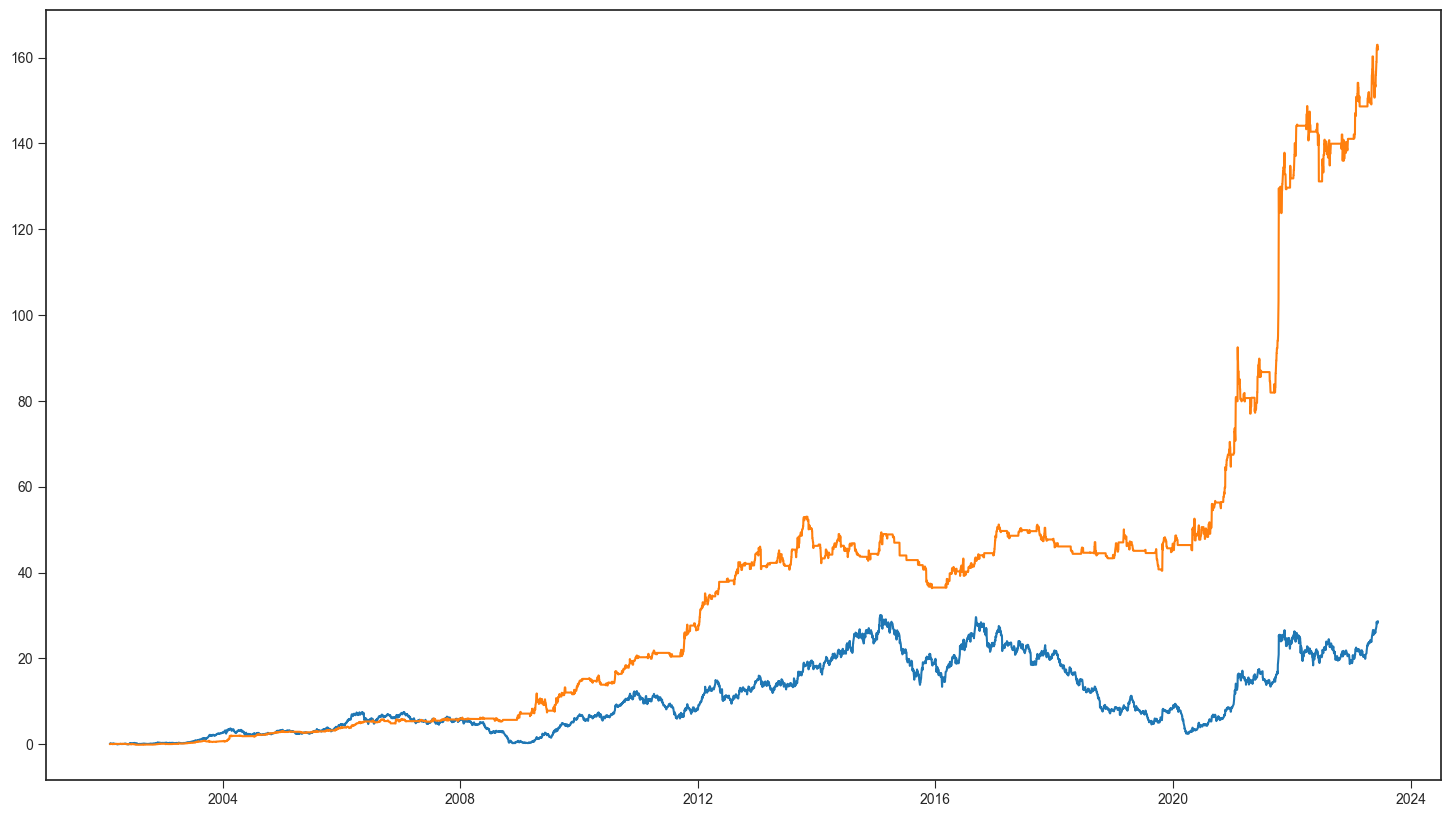

In [17]:
# Plot Equity Curves
fig = plt.figure(figsize = (18, 10))
plt.plot(df_main["bench_prod_exp"])
plt.plot(df_main["strat_prod_exp"])
plt.show()

### Save Data

In [18]:
# Save Data
df_main.to_csv("data/HMM-SPY.csv")

### Conclusion

It is clear that the moving average cross-over strategy performs vastly better in both returns and Sharpe Ratio, when trading only in favourable hidden states determined by the Hidden Markov Model unsupervised learning method.

CAUTION: Backtesting is fraught with areas of inconsitency. The price assumptions made in our strategy for backtesting are highly unlikely going to be like prices based on a real trading environment. "Backtesting is not a research tool. Feature Importance is". - Marcos Lopez De Prado (Author of Advances in Financial Machine Learning).